In [1]:
import fastprogress
import pandas as pd
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.vision.augment import *
from img_tools import *
import os

# Setup
### Load dataset

In [2]:
experiment_number=13
df = pd.read_csv("../data/train_clean_dataset.csv")
df["filepath"]=df["filepath"].apply(lambda x:Path(x))
df

,Unnamed: 0,site,str_file_path,class,image,filepath,height,width,size,has_correct_exposition
0,107183,S0157,../data/train_features/ZJ008255.jpg,monkey_prosimian,ZJ008255.jpg,../data/train_features/ZJ008255.jpg,360,640,"(640, 360)",True
1,111629,S0026,../data/train_features/ZJ012701.jpg,monkey_prosimian,ZJ012701.jpg,../data/train_features/ZJ012701.jpg,360,640,"(640, 360)",True
2,115246,S0089,../data/train_features/ZJ016318.jpg,monkey_prosimian,ZJ016318.jpg,../data/train_features/ZJ016318.jpg,360,640,"(640, 360)",True
3,112288,S0036,../data/train_features/ZJ013360.jpg,monkey_prosimian,ZJ013360.jpg,../data/train_features/ZJ013360.jpg,360,640,"(640, 360)",True
4,104774,S0009,../data/train_features/ZJ005846.jpg,monkey_prosimian,ZJ005846.jpg,../data/train_features/ZJ005846.jpg,360,640,"(640, 360)",True
...,...,...,...,...,...,...,...,...,...,...
11915,115377,S0022,../data/train_features/ZJ016449.jpg,monkey_prosimian,ZJ016449.jpg,../data/train_features/ZJ016449.jpg,360,640,"(640, 360)",True
11916,115396,S0070,../data/train_features/ZJ016468.jpg,monkey_prosimian,ZJ016468.jpg,../data/train_features/ZJ016468.jpg,540,960,"(960, 540)",True
11917,115397,S0031,../data/train_features/ZJ016469.jpg,monkey_prosimian,ZJ016469.jpg,../data/train_features/ZJ016469.jpg,360,640,"(640, 360)",True
11918,115398,S0002,../data/train_features/ZJ016470.jpg,monkey_prosimian,ZJ016470.jpg,../data/train_features/ZJ016470.jpg,360,640,"(640, 360)",True


In [3]:
def get_label_from_df(img_file):
    label = df[df["image"]==img_file]["class"].values[0]
    return label

tfms = [
    Rotate(max_deg=180),
    Zoom(min_zoom=0.5, max_zoom=2, p=0.75),
    Brightness(max_lighting=0.9),
    RandomErasing(sh=0.15, max_count=6, p=0.5),
    Normalize.from_stats(*imagenet_stats)
]

dls = ImageDataLoaders.from_name_func(".",df["filepath"].tolist(),get_label_from_df, bs=60, item_tfms=Resize(224), batch_tfms=tfms)

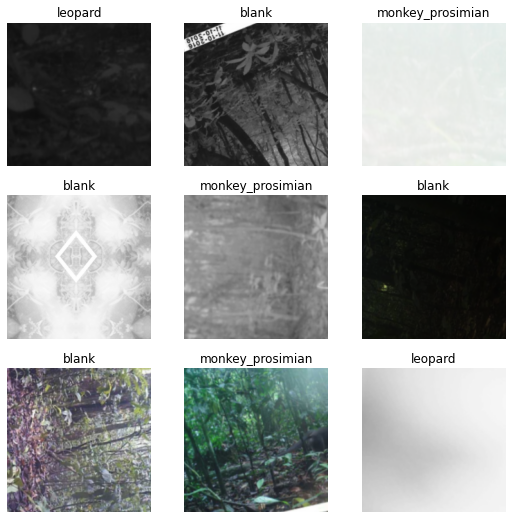

In [6]:
dls.show_batch()

### Configure learner by using a pre-trained model

In [14]:
learn = vision_learner(dls, models.resnet101,
                       metrics=[error_rate, F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')],
                       cbs=[
                            ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, patience=2, min_lr=1e-8),
                            EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=10),
                            SaveModelCallback(monitor='valid_loss'),
                            ShowGraphCallback()
                            ]
                       )

### Find the learning rate

SuggestedLRs(valley=0.0014454397605732083)

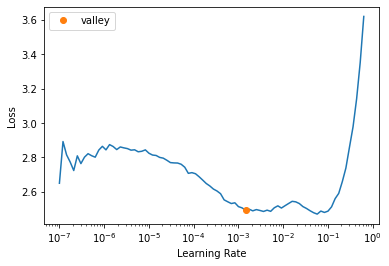

In [15]:
learn.lr_find()

# Train the model

In [ ]:
learn.fit(200, lr=0.001)

### Export the trained model

epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,1.652854,1.068153,0.398490,0.564353,0.596191,0.597628,01:07
1,1.352078,0.867366,0.360319,0.639676,0.648413,0.637939,01:07
2,1.164024,0.792717,0.333054,0.661952,0.660353,0.666203,01:09
3,1.080492,0.752479,0.315017,0.682401,0.691953,0.682420,01:09
4,1.041595,0.699190,0.295302,0.702637,0.704572,0.704145,01:09
5,0.961821,0.704353,0.278523,0.716151,0.716085,0.720664,01:09
6,0.913251,0.654236,0.257550,0.737737,0.736996,0.740987,01:10
7,0.889848,0.618366,0.244127,0.756637,0.762252,0.755157,01:10
8,0.874639,0.611103,0.247903,0.750040,0.755599,0.749615,01:09
9,0.848448,0.597480,0.229866,0.763518,0.767562,0.768185,01:10


Better model found at epoch 0 with valid_loss value: 1.0681531429290771.


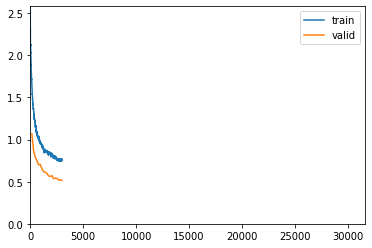

Better model found at epoch 1 with valid_loss value: 0.8673655986785889.
Better model found at epoch 2 with valid_loss value: 0.792716920375824.
Better model found at epoch 3 with valid_loss value: 0.7524786591529846.
Better model found at epoch 4 with valid_loss value: 0.6991904973983765.
Better model found at epoch 6 with valid_loss value: 0.6542355418205261.
Better model found at epoch 7 with valid_loss value: 0.6183658838272095.
Better model found at epoch 8 with valid_loss value: 0.6111025214195251.
Better model found at epoch 9 with valid_loss value: 0.5974801182746887.
Better model found at epoch 10 with valid_loss value: 0.56759113073349.
Better model found at epoch 11 with valid_loss value: 0.5627355575561523.
Better model found at epoch 13 with valid_loss value: 0.5351287126541138.
Better model found at epoch 16 with valid_loss value: 0.5205937623977661.
Better model found at epoch 18 with valid_loss value: 0.5148417353630066.


In [ ]:
learn.export(f"models/model-stage{experiment_number}.pkl")
learn.load("model")
learn.export(f"models/model-stage{experiment_number}best.pkl")

### Fine tuning (Optional)

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit(100, 3.02e-05)

In [ ]:
learn.load("model")
learn.export(f"models/model-stage{experiment_number}ft.pkl")

### Analyse the confusion matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Quick tests

In [ ]:
learn.predict(Path("../data/test_features/ZJ016585.jpg"))

In [ ]:
learn.predict(Path("../data/test_features/ZJ016585.jpg"))